# Stationarity

This note discusses stationarity via examples of 
* GDP vs Growth
* Price Index vs Inflation

In [1]:
import pandas as pd
import pandas_datareader as pdr
import datetime

import numpy as np
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import fsolve  

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               StrMethodFormatter,
                               AutoMinorLocator)

In [2]:
STARTDATE = '1980-01-01'
ENDDATE = '2022-03-31'

In [3]:
startdate = pd.to_datetime(STARTDATE)
enddate = pd.to_datetime(ENDDATE)

ticks = ['CPILFESL','USRECD','GDP','PCE','GPDI']
labels = ['CPI-Core','Recession','GDP','Consumption','Investment']

rawdata = pdr.DataReader(ticks,'fred',startdate,enddate)
rawdata.index.name = 'date'
rawdata.index = pd.to_datetime(rawdata.index)
rawdata.columns = labels

In [4]:
FREQ = 4

if FREQ == 4:
    FREQcode = 'Q'
elif FREQ == 1:
    FREQcode = 'Y'
elif FREQ==12:
    FREQcode = 'M'

data = rawdata.resample(FREQcode).agg('last')
data.index = data.index - pd.tseries.offsets.BDay(1)

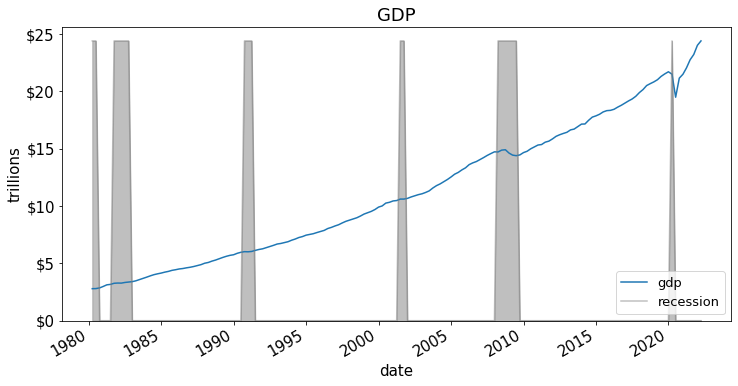

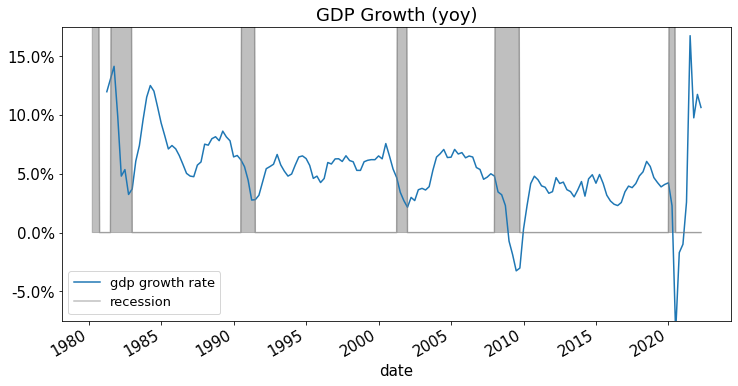

In [5]:
ax = (data['GDP']/1000).plot(ylabel='trillions')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
(data['Recession']*data['GDP'].max()/1000).plot.area(ax=ax, alpha=0.5,color='gray')

plt.title('GDP')
plt.legend(['gdp','recession'])
plt.show()


gdp_growth_yoy = (data['GDP'] / data['GDP'].shift(FREQ) - 1)
ax = gdp_growth_yoy.plot()
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
data['Recession'].plot.area(ax=ax, alpha=0.5,color='gray')

plt.title('GDP Growth (yoy)')
plt.ylim(-.075,.175)
plt.legend(['gdp growth rate','recession'])
plt.show()

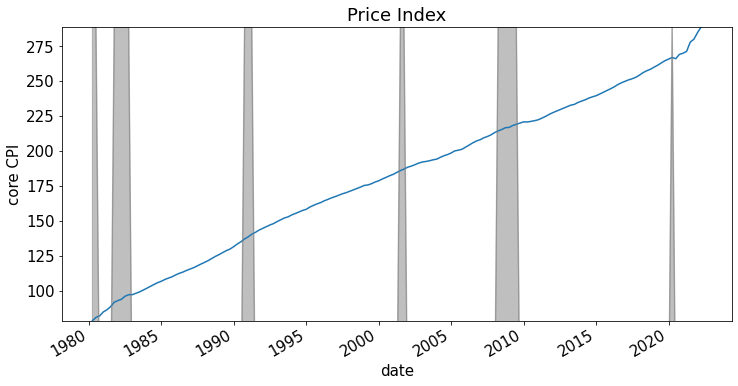

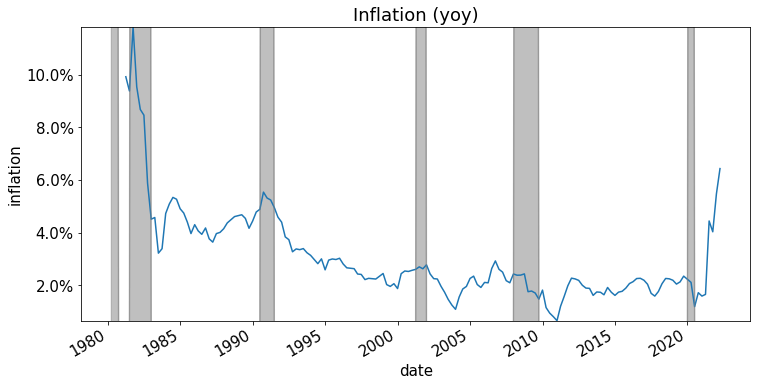

In [6]:
prices = data['CPI-Core']
ax = prices.plot(title='Price Index',ylabel='core CPI')
(data['Recession'] * prices.max()).plot.area(ax=ax, alpha=0.5,color='gray')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.ylim(prices.min(),prices.max())
plt.show()

inflation_yoy = (data['CPI-Core']/data['CPI-Core'].shift(FREQ) -1 )
ax = inflation_yoy.plot(title='Inflation (yoy)',ylabel='inflation')
data['Recession'].plot.area(ax=ax, alpha=0.5,color='gray')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
plt.ylim(inflation_yoy.min(),inflation_yoy.max())
plt.show()

# Non-Stationary Series and Diverging Moments

### For nonstationary, 
* expected values diverge as forecast horizon increases.

### For stationary
* expected value may be well defined

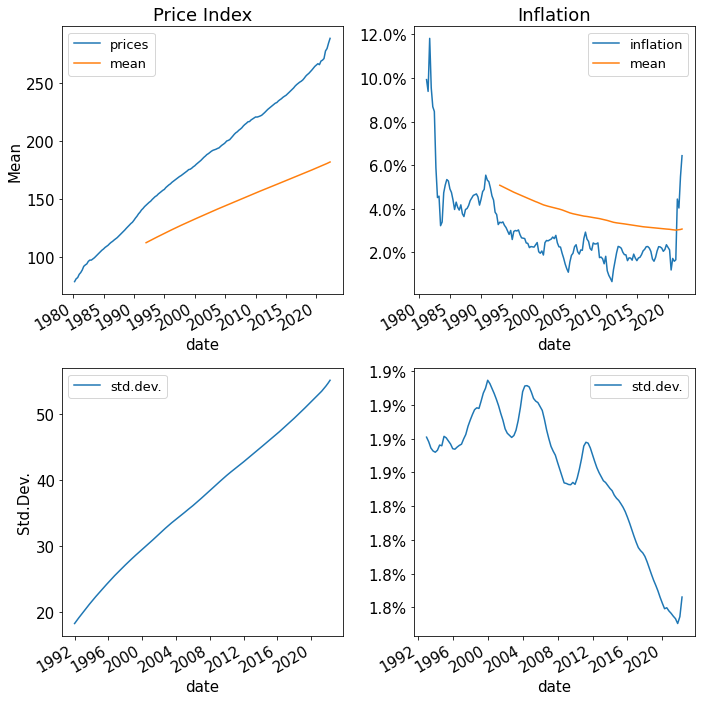

In [7]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

nburn = 48
prices.plot(ax=ax[0,0])
prices.expanding(nburn).mean().plot(title='Price Index',ax=ax[0,0],ylabel='Mean')
prices.expanding(nburn).std().plot(ax=ax[1,0],ylabel='Std.Dev.')

inflation_yoy.plot(ax=ax[0,1])
inflation_yoy.expanding(nburn).mean().plot(title='Inflation',ax=ax[0,1])
inflation_yoy.expanding(nburn).std().plot(ax=ax[1,1])



ax[0,0].legend(['prices','mean'])
ax[0,1].legend(['inflation','mean'])
ax[1,0].legend(['std.dev.'])
ax[1,1].legend(['std.dev.'])

ax[0,1].yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
ax[1,1].yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))

plt.tight_layout()
plt.show()

## Transformations

* differencing
* growth rates
* co-integration

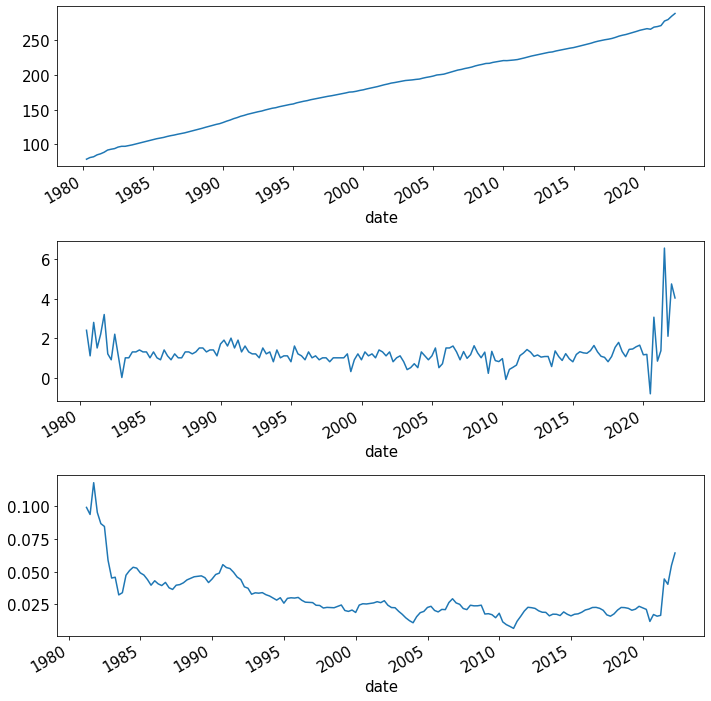

In [8]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
prices.plot(ax=ax[0])
inflation_yoy.plot(ax=ax[2])
prices.diff().plot(ax=ax[1])

plt.tight_layout()
plt.show()

# Cointegration

$$u = y - (\alpha + \beta x)$$

In [9]:
from arch.unitroot import engle_granger

y = data['Consumption']
x = data['GDP']

mod_con = engle_granger(y,x)
display(mod_con.summary())
display(mod_con.cointegrating_vector)

Test Statistic,-4.222
P-value,0.003
ADF Lag length,5
Estimated Root ρ (γ+1),0.453


Consumption      1.000000
GDP             -0.696873
const          296.976426
dtype: float64

In [10]:
y = data['Investment']
x = data['GDP']

mod_inv = engle_granger(y,x)
display(mod_inv.summary())
display(mod_inv.cointegrating_vector)

Test Statistic,-2.307
P-value,0.368
ADF Lag length,1
Estimated Root ρ (γ+1),0.939


Investment     1.000000
GDP           -0.171783
const        -34.290929
dtype: float64

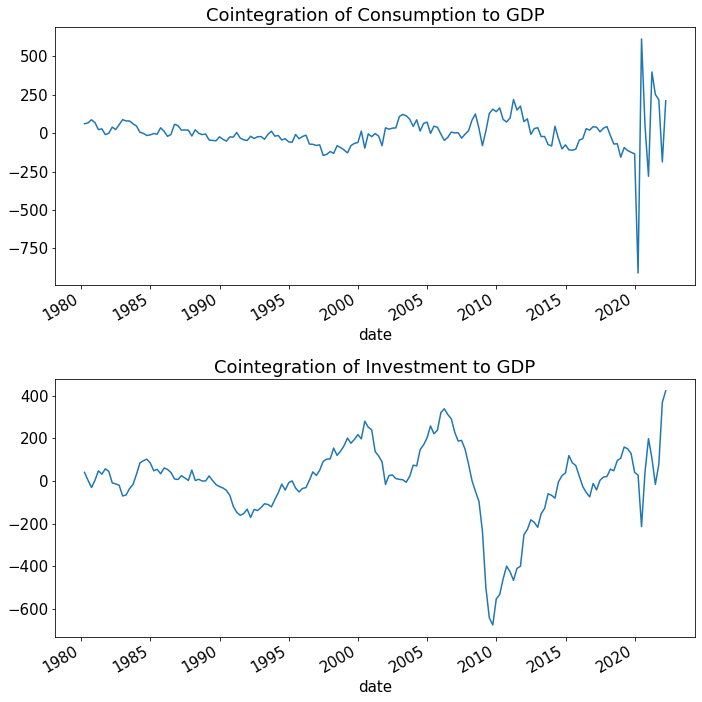

In [11]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
mod_con.resid.plot(ax=ax[0],title='Cointegration of Consumption to GDP')
mod_inv.resid.plot(ax=ax[1],title='Cointegration of Investment to GDP')

plt.tight_layout()
plt.show()